In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

pd.set_option('display.max_columns', 500)
gpu = torch.device('cuda:0')

%matplotlib inline
%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [8]:
lr = 0.001
epochs = 10
log_target = True
filters = (16, 16, 16)
hidden_layers = (100, 100)
latent_points = 5
latent_dims = 4

In [9]:
from utils.dataloader import ForSeaDataset


# ocean_data_path = '/home/knowit/Home_Foresee/forseeModel/data/copernicus/nrt/resampled/all_vars.nc'
ocean_data_path = '/home/knowit/Home_Foresee/forseeModel/data/copernicus/dataset/ocean_data.nc'
route_data_path = '/home/knowit/Home_Foresee/forseeModel/data/VMS_DCA_joined/cod_trawl.parquet'
dataset = ForSeaDataset(ocean_data_path, route_data_path, log_target=log_target, batched=True)
# dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

In [10]:
import torch
from models.LatentVariableNetwork import LatentVariableEncoder

encoder = LatentVariableEncoder(dataset.ocean_data_shape, filters, hidden_layers, latent_points=latent_points, latent_dims=latent_dims).cuda()

In [11]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=lr)

In [12]:
import gpytorch
import mlflow


# MLFlow
mlflow.set_experiment('/Experiments/Forsea')
with mlflow.start_run(run_name='LatentVariableNetwork1') as run:
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('lr', lr)
    mlflow.log_param('log_target', log_target)
    mlflow.log_param('filters', filters)
    mlflow.log_param('hidden_layers', hidden_layers)
    mlflow.log_param('latent_points', latent_points)

    encoder.train()
    print_period = 500
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = 0 
        for i, data in enumerate(dataset):
            (ocean_input, route_input), roundweight = data
            if len(route_input) == 0: continue
            roundweight = roundweight[:,0]

            optimizer.zero_grad()
            gp_model, likelihood = encoder(ocean_input, return_gp_model=True)
            gp_model.eval()
            likelihood.eval()
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)
            outputs = gp_model(route_input)
            loss = -mll(outputs, roundweight)
            # loss = criterion(outputs, roundweight)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1
            # print statistics
            if num_batches % print_period == 0:
                print(f'[{epoch + 1}, {num_batches:5d}] | loss: {running_loss / num_batches:.3f}')
        print(f'[{epoch + 1}, {num_batches:5d}] | loss: {running_loss / num_batches:.3f}')
        mlflow.log_metric('train_loss', running_loss / num_batches, step=epoch+1)

[1,   500] | loss: 2.408
[1,  1000] | loss: 2.447
[1,  1500] | loss: 2.416
[1,  2000] | loss: 2.416
[1,  2500] | loss: 2.432
[1,  3000] | loss: 2.427
[1,  3500] | loss: 2.438
[1,  4000] | loss: 2.440
[1,  4326] | loss: 2.441
[2,   500] | loss: 2.429
[2,  1000] | loss: 2.462
[2,  1500] | loss: 2.469
[2,  2000] | loss: 2.451
[2,  2500] | loss: 2.467
[2,  3000] | loss: 2.460
[2,  3500] | loss: 2.459
[2,  4000] | loss: 2.445
[2,  4326] | loss: 2.441
[3,   500] | loss: 2.424
[3,  1000] | loss: 2.490
[3,  1500] | loss: 2.453
[3,  2000] | loss: 2.461
[3,  2500] | loss: 2.452
[3,  3000] | loss: 2.448
[3,  3500] | loss: 2.441
[3,  4000] | loss: 2.447
[3,  4326] | loss: 2.441
[4,   500] | loss: 2.383
[4,  1000] | loss: 2.387
[4,  1500] | loss: 2.398
[4,  2000] | loss: 2.415
[4,  2500] | loss: 2.430
[4,  3000] | loss: 2.433
[4,  3500] | loss: 2.431
[4,  4000] | loss: 2.434
[4,  4326] | loss: 2.441
[5,   500] | loss: 2.442
[5,  1000] | loss: 2.462
[5,  1500] | loss: 2.461
[5,  2000] | loss: 2.448


In [27]:
m0 = route_input[:,0].mean()
m1 = route_input[:,1].mean()
grid_x = dataset.ocean_data.x
grid_y = dataset.ocean_data.y
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
grid_X = grid_X.flatten()
grid_Y = grid_Y.flatten()
inference_x = torch.zeros((len(grid_X), 4))
inference_x[:,0] = m0
inference_x[:,1] = m1
inference_x[:,2] = torch.from_numpy(grid_X)
inference_x[:,3] = torch.from_numpy(grid_Y)
inference_x = inference_x.cuda()

In [28]:
import gpytorch

gp_model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(gp_model(inference_x))
    f_preds = gp_model(inference_x)
    # forecast = model(test_x)
    
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [33]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [34]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp = GPModel(route_input, roundweight[:,0], likelihood)

In [5]:
train_x = X[:1000]
train_y = y[:1000]

In [6]:
import gpytorch
from models.DeepKernelLearner import GPRegressionModel_tmp

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel_tmp(train_x, train_y, likelihood)

NN 4


In [7]:
training_iterations = 60
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

%time train()

/home/knowit/miniconda3/envs/forsea/lib/python3.11/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


CPU times: user 1min 51s, sys: 53.2 ms, total: 1min 51s
Wall time: 4.69 s


In [9]:
model.eval()
pred = model(train_x)
pred

/home/knowit/miniconda3/envs/forsea/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


MultivariateNormal(loc: torch.Size([1000]))

/home/knowit/miniconda3/envs/forsea/lib/python3.11/site-packages/torch/distributions/distribution.py:173: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 1000.

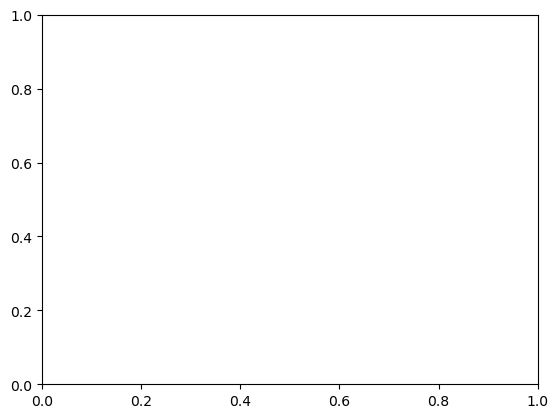

In [17]:
plt.scatter(train_x[:,-2], train_x[:,-1], c=pred.sample_n(10))
plt.show()